### Libraries

In [1]:
from dotenv import load_dotenv
import os
import neptune
import praw
from datetime import datetime, timedelta, timezone
import json
import time
from tqdm import tqdm
import regex as re

import numpy as np
import pandas as pd


# for text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from textblob import TextBlob

from pathlib import Path
Root = Path('.').absolute().parent
SCRIPTS = Root / r'scripts'
# SCRIPTS = Root / r'C:\Users\Admin\Projects\ML Projects\ManipDetect\research\scripts'
DATA = Root/ r'C:\Users\krishnadas\Projects\ML Projects\ManipDetect\data'

c:\Users\krishnadas\anaconda3\Lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  warnings.warn(


In [2]:
df = pd.read_csv(DATA / 'submissions_reddit.csv.zip', compression='zip')
df.head()

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,ko124i,[deleted],2021-01-01 00:02:06,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Gain,1.00,34,0,1,14,0,[deleted],default,https://redd.it/ko124i
1,ko12uq,[deleted],2021-01-01 00:03:20,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Gain,1.00,2,0,0,0,0,[deleted],default,https://redd.it/ko12uq
2,ko13df,[deleted],2021-01-01 00:04:11,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Meme,0.88,13,0,0,7,0,[deleted],default,https://redd.it/ko13df
3,ko17yf,shirotimatim,2021-01-01 00:11:51,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,0,0,...,News,0.92,183,0,0,26,0,NaN,https://b.thumbs.redditmedia.com/LmWdNB0W1qHT0...,https://redd.it/ko17yf
4,ko1a4i,WSBVoteBot,2021-01-01 00:15:38,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,0,0,...,NaN,0.50,0,0,0,19,0,Every time a new submission is posted to walls...,self,https://redd.it/ko1a4i


In [3]:
df['author'].value_counts().head(10)
# df['created_utc'] = pd.to_datetime(df['created'])

author
[deleted]               140686
Onboarding92               785
OPINION_IS_UNPOPULAR       630
RealPennyMuncher           204
Janto_2021                 196
DrioMarqui                 185
dailystockalert            170
Starlight-786              166
VisualMod                  161
pdwp90                     157
Name: count, dtype: int64

In [4]:
# Convert created column to datetime if it's not already
df_wsb = df.copy()
df_wsb['created'] = pd.to_datetime(df_wsb['created'])

In [5]:
"""
Initialize with known manipulation periods for labeling

manipulation_periods: list of tuples [(start_date, end_date), ...]
Example: [('2021-01-13', '2021-01-15'), ('2021-01-25', '2021-01-28')]
"""
manipulation_periods = [
    ('2021-01-13', '2021-01-15'),  # Initial coordination buildup
    ('2021-01-25', '2021-01-28'),  # Peak manipulation period
    ('2021-02-01', '2021-02-05')   # Sustained artificial activity
]

# Convert to datetime objects
manipulation_periods = [
    (pd.to_datetime(start), pd.to_datetime(end)) 
    for start, end in manipulation_periods
]

In [6]:
# select authors from manipulation periods
def select_authors_in_manipulation_periods(df, manipulation_periods):
    authors = set()
    for start, end in manipulation_periods:
        mask = (df['created'] >= start) & (df['created'] <= end)
        authors.update(df.loc[mask, 'author'].unique())
    return authors

selected_authors = select_authors_in_manipulation_periods(df_wsb, manipulation_periods)

In [7]:
# check if the selected authors contain deleted
deleted_authors = [authors for authors in selected_authors if authors == '[deleted]']
deleted_authors_count = len(deleted_authors)
print(f"Number of deleted authors in selected authors: {deleted_authors_count}")

Number of deleted authors in selected authors: 1


In [8]:
df_wsb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775326 entries, 0 to 775325
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     775326 non-null  object        
 1   author                 775326 non-null  object        
 2   created                775326 non-null  datetime64[ns]
 3   retrieved              775326 non-null  object        
 4   edited                 775326 non-null  object        
 5   pinned                 775326 non-null  int64         
 6   archived               775326 non-null  int64         
 7   locked                 775326 non-null  int64         
 8   removed                775326 non-null  int64         
 9   deleted                775326 non-null  int64         
 10  is_self                775326 non-null  int64         
 11  is_video               775326 non-null  int64         
 12  is_original_content    775326 non-null  int6

In [9]:
df_wsb.columns

Index(['id', 'author', 'created', 'retrieved', 'edited', 'pinned', 'archived',
       'locked', 'removed', 'deleted', 'is_self', 'is_video',
       'is_original_content', 'title', 'link_flair_text', 'upvote_ratio',
       'score', 'gilded', 'total_awards_received', 'num_comments',
       'num_crossposts', 'selftext', 'thumbnail', 'shortlink'],
      dtype='object')

In [10]:
# remove unnecessary columns
columns_to_remove = ['retrieved', 'edited', 'gilded', 'edited', 'pinned', 'archived','locked', 'total_awards_received',
                    'num_crossposts', 'thumbnail', 'link_flair_text']
df_wsb.drop(columns=columns_to_remove, inplace=True, errors='ignore')
print(df_wsb.columns)
df_wsb.head()

Index(['id', 'author', 'created', 'removed', 'deleted', 'is_self', 'is_video',
       'is_original_content', 'title', 'upvote_ratio', 'score', 'num_comments',
       'selftext', 'shortlink'],
      dtype='object')


,id,author,created,removed,deleted,is_self,is_video,is_original_content,title,upvote_ratio,score,num_comments,selftext,shortlink
0,ko124i,[deleted],2021-01-01 00:02:06,1,1,1,0,0,"3k - 170k since March (Also, buy LIT!!)",1.00,34,14,[deleted],https://redd.it/ko124i
1,ko12uq,[deleted],2021-01-01 00:03:20,1,1,0,0,0,Got out of PLTR calls after learning about IV ...,1.00,2,0,[deleted],https://redd.it/ko12uq
2,ko13df,[deleted],2021-01-01 00:04:11,1,1,0,0,0,Hell of a headline,0.88,13,7,[deleted],https://redd.it/ko13df
3,ko17yf,shirotimatim,2021-01-01 00:11:51,0,0,0,0,0,"Top popular stocks on WSB too! Also, why they ...",0.92,183,26,NaN,https://redd.it/ko17yf
4,ko1a4i,WSBVoteBot,2021-01-01 00:15:38,0,0,1,0,0,WSBVoteBot Log for Jan 01 2021,0.50,0,19,Every time a new submission is posted to walls...,https://redd.it/ko1a4i


In [11]:
col_names_to_change = ['id', 'created', 'selftext', 'num_comments', 'shortlink']
new_col_names = ['post id', 'timestamp', 'body', 'comms_num', 'url']
df_wsb.rename(columns=dict(zip(col_names_to_change, new_col_names)), inplace=True)

In [12]:
df_wsb['deleted'].value_counts(), df_wsb['removed'].value_counts(), df_wsb['is_original_content'].value_counts()

(deleted
 0    685664
 1     89662
 Name: count, dtype: int64,
 removed
 1    698970
 0     76356
 Name: count, dtype: int64,
 is_original_content
 0    760265
 1     15061
 Name: count, dtype: int64)

In [13]:
def _clean_text(text):
    """Clean and normalize text data"""
    if pd.isna(text):
        return ""
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.lower()

In [14]:
"""Load Reddit data and perform initial cleaning"""

# Convert timestamp to datetime
df_wsb['timestamp'] = pd.to_datetime(df_wsb['timestamp'])

# Filter for GameStop-related posts
gme_keywords = ['GME', 'GameStop', 'Gamestop', 'GAMESTOP']
df_wsb['is_gme'] = df_wsb['title'].str.contains('|'.join(gme_keywords), case=False, na=False) | \
                df_wsb['body'].str.contains('|'.join(gme_keywords), case=False, na=False)

# Keep only GME-related posts
df_wsb = df_wsb[df_wsb['is_gme']].copy()

# Clean text data
df_wsb['title_clean'] = df_wsb['title'].apply(_clean_text)
df_wsb['body_clean'] = df_wsb['body'].fillna('').apply(_clean_text)
df_wsb['combined_text'] = df_wsb['title_clean'] + ' ' + df_wsb['body_clean']

df_wsb.sort_values('timestamp').reset_index(drop=True)
df_wsb.head()


,post id,author,timestamp,removed,deleted,is_self,is_video,is_original_content,title,upvote_ratio,score,comms_num,body,url,is_gme,title_clean,body_clean,combined_text
5,ko1bnp,dluther93,2021-01-01 00:18:03,1,0,1,0,0,What would make GME shorts win?,1.00,1,0,[removed],https://redd.it/ko1bnp,True,what would make gme shorts win,removed,what would make gme shorts win removed
12,ko1kck,[deleted],2021-01-01 00:32:49,1,1,0,0,0,Not sure how reliable a random comment in Cohe...,0.93,80,33,[deleted],https://redd.it/ko1kck,True,not sure how reliable a random comment in cohe...,deleted,not sure how reliable a random comment in cohe...
21,ko1ttx,WSBProfitProphet,2021-01-01 00:49:32,1,0,1,0,0,🚀🚀🚀🚀How have we been so fucking blind? GME is ...,1.00,1,0,[removed],https://redd.it/ko1ttx,True,how have we been so fucking blind gme is liter...,removed,how have we been so fucking blind gme is liter...
25,ko1xxb,WSBProfitProphet,2021-01-01 00:56:35,0,0,1,0,0,GME is the Rockets 🚀🚀🚀🚀,0.82,57,10,"Gamestop colors: Red, White and Black\n\nHoust...",https://redd.it/ko1xxb,True,gme is the rockets,gamestop colors red white and black houston ro...,gme is the rockets gamestop colors red white a...
26,ko1zs3,WhiskeySierra1984,2021-01-01 00:59:55,1,0,0,0,0,Looked out the window of my PLTR/GME rocketshi...,0.90,75,8,NaN,https://redd.it/ko1zs3,True,looked out the window of my pltr gme rocketshi...,,looked out the window of my pltr gme rocketshi...


In [15]:
df_wsb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107499 entries, 5 to 775258
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   post id              107499 non-null  object        
 1   author               107499 non-null  object        
 2   timestamp            107499 non-null  datetime64[ns]
 3   removed              107499 non-null  int64         
 4   deleted              107499 non-null  int64         
 5   is_self              107499 non-null  int64         
 6   is_video             107499 non-null  int64         
 7   is_original_content  107499 non-null  int64         
 8   title                107499 non-null  object        
 9   upvote_ratio         107499 non-null  float64       
 10  score                107499 non-null  int64         
 11  comms_num            107499 non-null  int64         
 12  body                 75958 non-null   object        
 13  url                

In [16]:
# Extract post features
"""Extract features from individual posts"""

# Sentiment analysis
df_wsb['sentiment'] = df_wsb['combined_text'].apply(
    lambda x: TextBlob(x).sentiment.polarity if x else 0
)
df_wsb['sentiment_magnitude'] = df_wsb['combined_text'].apply(
    lambda x: abs(TextBlob(x).sentiment.polarity) if x else 0
)
df_wsb['subjectivity'] = df_wsb['combined_text'].apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)

# Text length features
df_wsb['title_length'] = df_wsb['title_clean'].str.len()
df_wsb['body_length'] = df_wsb['body_clean'].str.len()
df_wsb['total_length'] = df_wsb['title_length'] + df_wsb['body_length']

# Engagement features
df_wsb['engagement_score'] = df_wsb['score'] + df_wsb['comms_num']
df_wsb['score_per_comment'] = df_wsb['score'] / (df_wsb['comms_num'] + 1)  # Avoid division by zero

# Author features (anonymized but trackable patterns)
df_wsb['author_post_count'] = df_wsb.groupby('author')['author'].transform('count')
df_wsb.head()


,post id,author,timestamp,removed,deleted,is_self,is_video,is_original_content,title,upvote_ratio,...,combined_text,sentiment,sentiment_magnitude,subjectivity,title_length,body_length,total_length,engagement_score,score_per_comment,author_post_count
5,ko1bnp,dluther93,2021-01-01 00:18:03,1,0,1,0,0,What would make GME shorts win?,1.00,...,what would make gme shorts win removed,0.800000,0.800000,0.400000,30,7,37,1,1.000000,1
12,ko1kck,[deleted],2021-01-01 00:32:49,1,1,0,0,0,Not sure how reliable a random comment in Cohe...,0.93,...,not sure how reliable a random comment in cohe...,-0.450000,0.450000,0.696296,97,7,104,113,2.352941,21745
21,ko1ttx,WSBProfitProphet,2021-01-01 00:49:32,1,0,1,0,0,🚀🚀🚀🚀How have we been so fucking blind? GME is ...,1.00,...,how have we been so fucking blind gme is liter...,-0.500000,0.500000,0.666667,62,7,69,1,1.000000,2
25,ko1xxb,WSBProfitProphet,2021-01-01 00:56:35,0,0,1,0,0,GME is the Rockets 🚀🚀🚀🚀,0.82,...,gme is the rockets gamestop colors red white a...,-0.009871,0.009871,0.281448,18,964,982,67,5.181818,2
26,ko1zs3,WhiskeySierra1984,2021-01-01 00:59:55,1,0,0,0,0,Looked out the window of my PLTR/GME rocketshi...,0.90,...,looked out the window of my pltr gme rocketshi...,0.000000,0.000000,0.000000,70,0,70,83,8.333333,2


In [17]:
# Calculate text similarity within time windows
window_hours=1
# Group posts by hour windows
df_wsb['hour_window'] = df_wsb['timestamp'].dt.floor(f'{window_hours}H')

similarity_scores = []

for window, group in df_wsb.groupby('hour_window'):
    if len(group) < 2:
        # If only one post in window, similarity is 0
        similarity_scores.extend([0] * len(group))
        continue
        
    # Calculate TF-IDF similarity
    texts = group['combined_text'].fillna('').tolist()
    
    try:
        vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(texts)
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        # Average similarity for each post to all others in the window
        avg_similarities = []
        for i in range(len(similarity_matrix)):
            # Exclude self-similarity (diagonal = 1)
            others = np.concatenate([similarity_matrix[i][:i], similarity_matrix[i][i+1:]])
            avg_similarity = np.mean(others) if len(others) > 0 else 0
            avg_similarities.append(avg_similarity)
            
        similarity_scores.extend(avg_similarities)
        
    except:
        # If TF-IDF fails (e.g., empty texts), set similarity to 0
        similarity_scores.extend([0] * len(group))

df_wsb['text_similarity'] = similarity_scores
df_wsb.head()


,post id,author,timestamp,removed,deleted,is_self,is_video,is_original_content,title,upvote_ratio,...,sentiment_magnitude,subjectivity,title_length,body_length,total_length,engagement_score,score_per_comment,author_post_count,hour_window,text_similarity
5,ko1bnp,dluther93,2021-01-01 00:18:03,1,0,1,0,0,What would make GME shorts win?,1.00,...,0.800000,0.400000,30,7,37,1,1.000000,1,2021-01-01,0.122080
12,ko1kck,[deleted],2021-01-01 00:32:49,1,1,0,0,0,Not sure how reliable a random comment in Cohe...,0.93,...,0.450000,0.696296,97,7,104,113,2.352941,21745,2021-01-01,0.055257
21,ko1ttx,WSBProfitProphet,2021-01-01 00:49:32,1,0,1,0,0,🚀🚀🚀🚀How have we been so fucking blind? GME is ...,1.00,...,0.500000,0.666667,62,7,69,1,1.000000,2,2021-01-01,0.120343
25,ko1xxb,WSBProfitProphet,2021-01-01 00:56:35,0,0,1,0,0,GME is the Rockets 🚀🚀🚀🚀,0.82,...,0.009871,0.281448,18,964,982,67,5.181818,2,2021-01-01,0.058473
26,ko1zs3,WhiskeySierra1984,2021-01-01 00:59:55,1,0,0,0,0,Looked out the window of my PLTR/GME rocketshi...,0.90,...,0.000000,0.000000,70,0,70,83,8.333333,2,2021-01-01,0.034244


In [162]:
def _aggregate_to_hourly(df):
        """Aggregate posts to hourly features"""
        df['hour'] = df['timestamp'].dt.floor('H')
        
        hourly_agg = df.groupby('hour').agg({
            'sentiment': ['mean', 'min', 'max'], # No need of std
            'sentiment_magnitude': 'mean',
            'text_similarity': 'mean',
            'score': ['sum', 'mean'],    # No need of std
            'comms_num': ['sum', 'mean'],
            'engagement_score': ['sum', 'mean'],
            'author': 'nunique',  # Unique authors per hour
            'author_post_count': 'mean',  # Average posts per author
            'total_length': 'mean',
            'timestamp': 'count'  # Post volume
        }).round(4)
        
        # Flatten column names
        # col_name = hourly_agg.columns
        # print(hourly_agg.columns)
        # print([f'{col[0]}_{col[1]}' if col[1] else col[0] 
                            # for col in hourly_agg.columns])
        hourly_agg.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] 
                            for col in hourly_agg.columns]
        
        # Rename count column
        hourly_agg = hourly_agg.rename(columns={'timestamp_count': 'post_volume'})
        
        # Add coordination signals
        hourly_agg['author_diversity'] = hourly_agg['author_nunique'] / (hourly_agg['post_volume'] + 1)
        hourly_agg['repeat_poster_ratio'] = 1 - hourly_agg['author_diversity']
        # Add the orginal features
    
        
        return hourly_agg.reset_index()
    
def _aggregate_to_daily(hourly_df):
    """Aggregate hourly features to daily"""
    hourly_df['date'] = hourly_df['hour'].dt.date
    
    # Select key features for daily aggregation
    daily_agg = hourly_df.groupby('date').agg({
        'sentiment_mean': 'mean',  # No need of std
        # 'sentiment_std': 'mean',
        'text_similarity_mean': 'mean',
        'post_volume': ['sum', 'mean', 'max'],   # No need of std
        'score_sum': 'sum',
        'engagement_score_sum': 'sum',
        'author_diversity': 'mean',
        'repeat_poster_ratio': 'mean',
    }).round(4)
    
    # Flatten column names
    # col_names = daily_agg.columns
    # print(col_names)
    daily_agg.columns = [f'daily_{col[0]}' if re.search(r'_[mean|sum|max]', col[0]) 
                            else f'daily_{col[0]}_{col[1]}'
                        for col in daily_agg.columns]
    
    return daily_agg.reset_index()
    
def _aggregate_to_weekly(daily_df):
    """Aggregate daily features to weekly"""
    daily_df['week'] = pd.to_datetime(daily_df['date']).dt.to_period('W')
    # I only wanted to have a list intsead of multiindex
    weekly_agg = daily_df.groupby('week').agg({
        'daily_sentiment_mean': 'mean',
        'daily_post_volume_sum': 'sum',
        'daily_score_sum': 'sum',
        'daily_author_diversity_mean': 'mean',
    }).round(4)
    
    # Flatten column names
    # col_names = weekly_agg.columns
    # print(col_names)
    weekly_agg.columns = [f'weekly_{col}' for col in weekly_agg.columns]
    # change the column names to remove the word "_daily_"
    weekly_agg.columns = [col.replace('daily_', '') for col in weekly_agg.columns]  
    return weekly_agg.reset_index()

In [212]:
"""Create features at different time scales"""

# Level 1: Hourly aggregation
hourly_features = _aggregate_to_hourly(df_wsb)

# Level 2: Daily aggregation
daily_features = _aggregate_to_daily(hourly_features)

# Level 3: Weekly aggregation (for longer patterns)
weekly_features = _aggregate_to_weekly(daily_features)

In [218]:
def label_manipulation_periods(df):
        """Label time periods as manipulation (1) or normal (0)"""
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['is_manipulation'] = 0
        
        for start_date, end_date in manipulation_periods:
            mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
            df.loc[mask, 'is_manipulation'] = 1
            
        return df

def label_manipulation_periods_sequence(df, sequence:str, sequence_name:str):
        """Label time periods as manipulation (1) or normal (0)"""
        assert sequence in ['daily', 'hourly', 'weekly'], \
            "Invalid sequence type. Choose from 'daily', 'hourly', or 'weekly'."
        df['is_manipulation'] = 0
        try:
            if sequence == 'daily':
                df['date'] = pd.to_datetime(df['date'])
            elif sequence == 'hourly':
                df['hour'] = pd.to_datetime(df['hour'])
            elif sequence == 'weekly':
                df['week'] = df['week'].dt.to_timestamp()
            else:
                raise ValueError("Invalid sequence type. Choose from 'daily', 'hourly', or 'weekly'.")
            for start_date, end_date in manipulation_periods:
                mask = (df[sequence_name] >= start_date) & (df[sequence_name] <= end_date)
                df.loc[mask, 'is_manipulation'] = 1
        except Exception as e:
            print(f"Error labeling manipulation periods: {e}")
            return df
            
        return df

def prepare_lstm_sequences(df, sequence:str, sequence_name:str, sequence_length:int):
    """Prepare sequences for LSTM training
    Choose the correct df based on the sequence type
    sequence: 'daily', 'hourly', or 'weekly'
    sequence_name: 'date', 'hour', or 'week'
    """
    assert sequence in ['daily', 'hourly', 'weekly'], \
        "Invalid sequence type. Choose from 'daily', 'hourly', or 'weekly'."
    assert sequence_name in ['date', 'hour', 'week'], \
        "Invalid sequence name. Choose from 'date', 'hour', or 'week'."
    assert sequence_length in [7, 24, 4], \
        "Invalid sequence length. Choose from 7 (daily), 24 (hourly), or 4 (weekly)."
    try:
        # df = label_manipulation_periods_sequence(df, sequence, sequence_name)
        df = df.sort_values(sequence_name).reset_index(drop=True)
        # Select feature columns (exclude date and target)
        feature_cols = [col for col in df.columns 
                        if col not in [sequence_name, 'is_manipulation']]
        # Create sequences
        X, y = [], []
        
        for i in range(sequence_length, len(df)):
            # Use previous 7 days to predict current day
            X.append(df[feature_cols].iloc[i-sequence_length:i].values)
            y.append(df['is_manipulation'].iloc[i])
        
    except Exception as e:
        print(f"Error preparing sequences: {e}")
        return None, None, None
    
    return np.array(X), np.array(y), feature_cols

def prepare_daily_sequences(daily_df, sequence_length=7):
    """Prepare sequences for LSTM training"""
    
    # Sort by date
    daily_df = daily_df.sort_values('date').reset_index(drop=True)
    
    # Select feature columns (exclude date and target)
    feature_cols = [col for col in daily_df.columns 
                    if col not in ['date', 'is_manipulation']]
    
    # Create sequences
    X, y = [], []
    
    for i in range(sequence_length, len(daily_df)):
        # Use previous 7 days to predict current day
        X.append(daily_df[feature_cols].iloc[i-sequence_length:i].values)
        y.append(daily_df['is_manipulation'].iloc[i])
    
    return np.array(X), np.array(y), feature_cols



def get_preprocessing_summary(df):
        """Print summary of preprocessing results"""
        print("=== Preprocessing Summary ===")
        print(f"Total GME posts: {len(df)}")
        print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        print(f"Unique authors: {df['author'].nunique()}")
        print(f"Average sentiment: {df['sentiment'].mean():.3f}")
        print(f"Average text similarity: {df['text_similarity'].mean():.3f}")
        print(f"Deleted Authors: {df['author'].value_counts().get('[deleted]', 0)}")
        
        # Manipulation period stats
        manipulation_posts = 0
        for start, end in manipulation_periods:
            mask = (df['timestamp'] >= start) & (df['timestamp'] <= end)
            manipulation_posts += mask.sum()
            print(f"Posts during {start.date()} to {end.date()}: {mask.sum()}")
        
        print(f"Total manipulation period posts: {manipulation_posts}")
        print(f"Normal period posts: {len(df) - manipulation_posts}")


In [219]:
df_wsb_labeled = label_manipulation_periods(df_wsb)
df_wsb_labeled.head()

,post id,author,timestamp,removed,deleted,is_self,is_video,is_original_content,title,upvote_ratio,...,title_length,body_length,total_length,engagement_score,score_per_comment,author_post_count,hour_window,text_similarity,hour,is_manipulation
5,ko1bnp,dluther93,2021-01-01 00:18:03,1,0,1,0,0,What would make GME shorts win?,1.00,...,30,7,37,1,1.000000,1,2021-01-01,0.122080,2021-01-01,0
12,ko1kck,[deleted],2021-01-01 00:32:49,1,1,0,0,0,Not sure how reliable a random comment in Cohe...,0.93,...,97,7,104,113,2.352941,21745,2021-01-01,0.055257,2021-01-01,0
21,ko1ttx,WSBProfitProphet,2021-01-01 00:49:32,1,0,1,0,0,🚀🚀🚀🚀How have we been so fucking blind? GME is ...,1.00,...,62,7,69,1,1.000000,2,2021-01-01,0.120343,2021-01-01,0
25,ko1xxb,WSBProfitProphet,2021-01-01 00:56:35,0,0,1,0,0,GME is the Rockets 🚀🚀🚀🚀,0.82,...,18,964,982,67,5.181818,2,2021-01-01,0.058473,2021-01-01,0
26,ko1zs3,WhiskeySierra1984,2021-01-01 00:59:55,1,0,0,0,0,Looked out the window of my PLTR/GME rocketshi...,0.90,...,70,0,70,83,8.333333,2,2021-01-01,0.034244,2021-01-01,0


In [214]:
hourly_labeled = label_manipulation_periods_sequence(hourly_features, 'hourly', 'hour')
X_hourly, y_hourly, feature_cols_hourly = prepare_lstm_sequences(hourly_labeled, sequence='hourly', sequence_name='hour', sequence_length=24)

daily_labeled = label_manipulation_periods_sequence(daily_features, 'daily', 'date')
X_daily, y_daily, feature_cols_daily = prepare_lstm_sequences(daily_labeled, sequence='daily', sequence_name='date', sequence_length=7)

weekly_labeled = label_manipulation_periods_sequence(weekly_features, 'weekly', 'week')
X_weekly, y_weekly, feature_cols_weekly = prepare_lstm_sequences(weekly_labeled, sequence='weekly', sequence_name='week', sequence_length=4)

In [211]:
weekly_features['week']

0    2020-12-28
1    2021-01-04
2    2021-01-11
3    2021-01-18
4    2021-01-25
5    2021-02-01
6    2021-02-08
7    2021-02-15
8    2021-02-22
9    2021-03-01
10   2021-03-08
11   2021-03-15
12   2021-03-22
13   2021-03-29
14   2021-04-05
15   2021-04-12
16   2021-04-19
17   2021-04-26
18   2021-05-03
19   2021-05-10
20   2021-05-17
21   2021-05-24
22   2021-05-31
23   2021-06-07
24   2021-06-14
25   2021-06-21
26   2021-06-28
27   2021-07-05
28   2021-07-12
29   2021-07-19
30   2021-07-26
31   2021-08-02
32   2021-08-09
33   2021-08-16
34   2021-08-23
35   2021-08-30
36   2021-09-06
37   2021-09-13
38   2021-09-20
39   2021-09-27
40   2021-10-04
41   2021-10-11
42   2021-10-18
43   2021-10-25
44   2021-11-01
45   2021-11-08
46   2021-11-15
47   2021-11-22
48   2021-11-29
49   2021-12-06
50   2021-12-13
51   2021-12-20
52   2021-12-27
Name: week, dtype: datetime64[ns]

In [ ]:
# Label manipulation periods
daily_labeled = label_manipulation_periods(daily_features)
# weekly_labeled = label_manipulation_periods(weekly_features)


# Prepare LSTM sequences
X, y, feature_names = prepare_daily_sequences(daily_labeled)



In [31]:
# Print summary
get_preprocessing_summary(df_wsb)

=== Preprocessing Summary ===
Total GME posts: 107499
Date range: 2021-01-01 00:18:03 to 2021-12-31 21:25:28
Unique authors: 66126
Average sentiment: 0.031
Average text similarity: 0.126
Deleted Authors: 21745
Posts during 2021-01-13 to 2021-01-15: 1160
Posts during 2021-01-25 to 2021-01-28: 12615
Posts during 2021-02-01 to 2021-02-05: 5682
Total manipulation period posts: 19457
Normal period posts: 88042


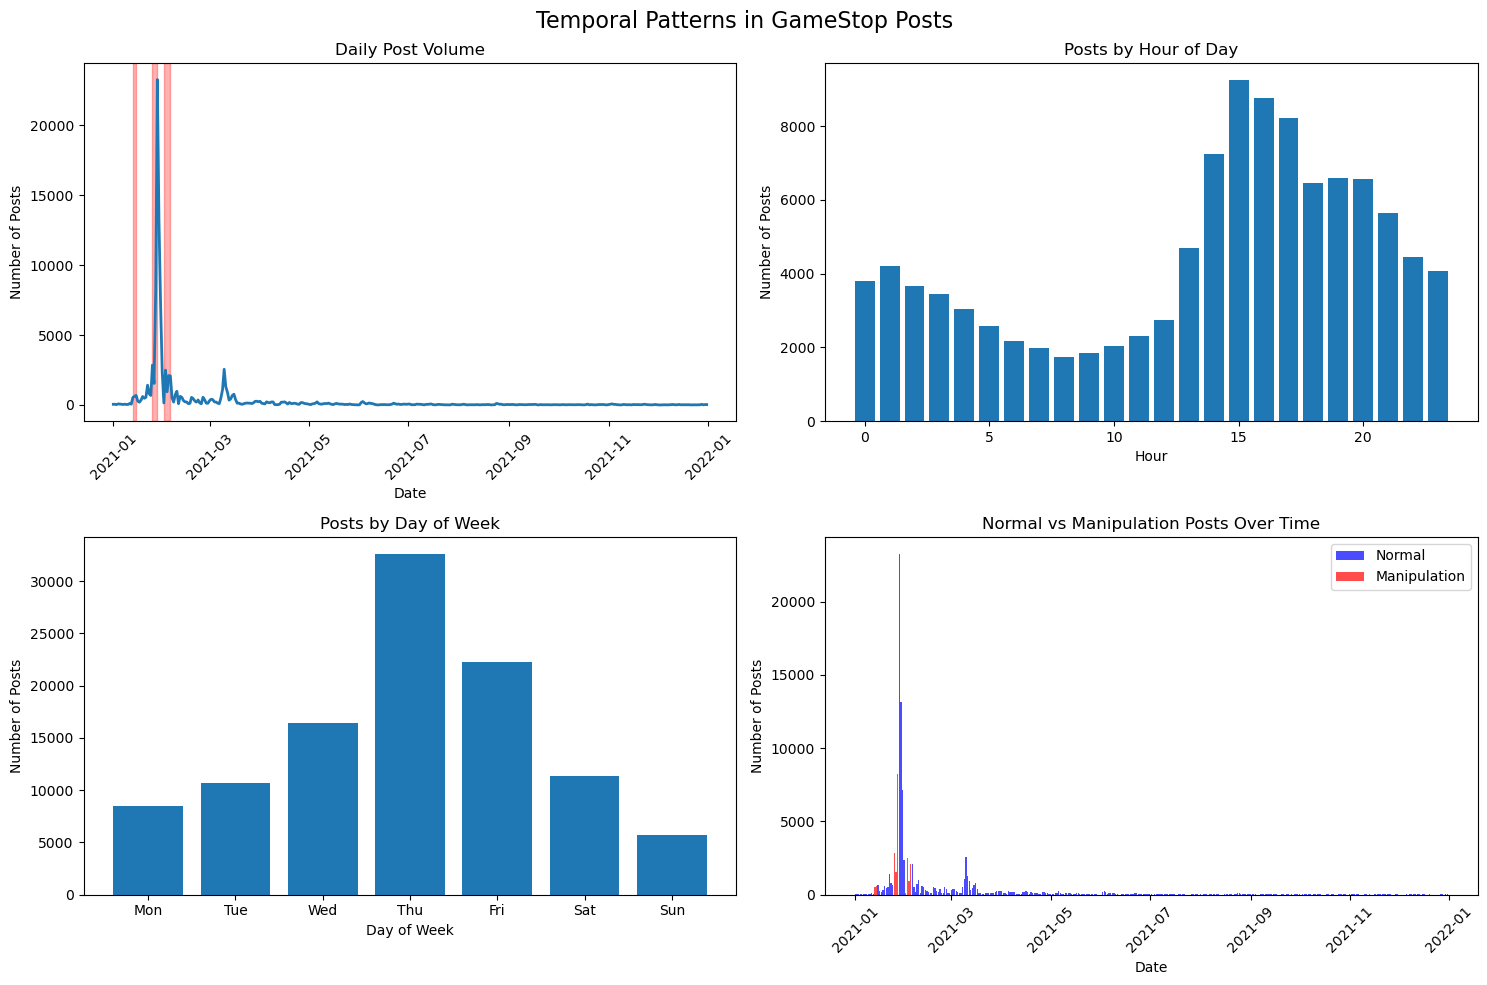

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Temporal Patterns in GameStop Posts', fontsize=16)

# 1. Posts over time
daily_posts = df_wsb_labeled.groupby(df_wsb_labeled['timestamp'].dt.date).size()
axes[0, 0].plot(daily_posts.index, daily_posts.values, linewidth=2)
axes[0, 0].set_title('Daily Post Volume')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Posts')
axes[0, 0].tick_params(axis='x', rotation=45)

# Highlight manipulation periods
for start, end in manipulation_periods:
    axes[0, 0].axvspan(start.date(), end.date(), alpha=0.3, color='red', label='Manipulation Period')

# 2. Posts by hour of day
hourly_posts = df_wsb_labeled.groupby(df_wsb_labeled['timestamp'].dt.hour).size()
axes[0, 1].bar(hourly_posts.index, hourly_posts.values)
axes[0, 1].set_title('Posts by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Number of Posts')

# 3. Posts by day of week
daily_posts_dow = df_wsb_labeled.groupby(df_wsb_labeled['timestamp'].dt.dayofweek).size()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(range(7), daily_posts_dow.values)
axes[1, 0].set_title('Posts by Day of Week')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Posts')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(days)

# 4. Manipulation vs Normal periods
manip_daily = df_wsb_labeled[df_wsb_labeled['is_manipulation'] == 1].groupby(
    df_wsb_labeled[df_wsb_labeled['is_manipulation'] == 1]['timestamp'].dt.date
).size()
normal_daily = df_wsb_labeled[df_wsb_labeled['is_manipulation'] == 0].groupby(
    df_wsb_labeled[df_wsb_labeled['is_manipulation'] == 0]['timestamp'].dt.date
).size()

# Align dates for comparison
all_dates = daily_posts.index
manip_aligned = manip_daily.reindex(all_dates, fill_value=0)
normal_aligned = normal_daily.reindex(all_dates, fill_value=0)

axes[1, 1].bar(all_dates, normal_aligned.values, alpha=0.7, label='Normal', color='blue')
axes[1, 1].bar(all_dates, manip_aligned.values, alpha=0.7, label='Manipulation', color='red')
axes[1, 1].set_title('Normal vs Manipulation Posts Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Number of Posts')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

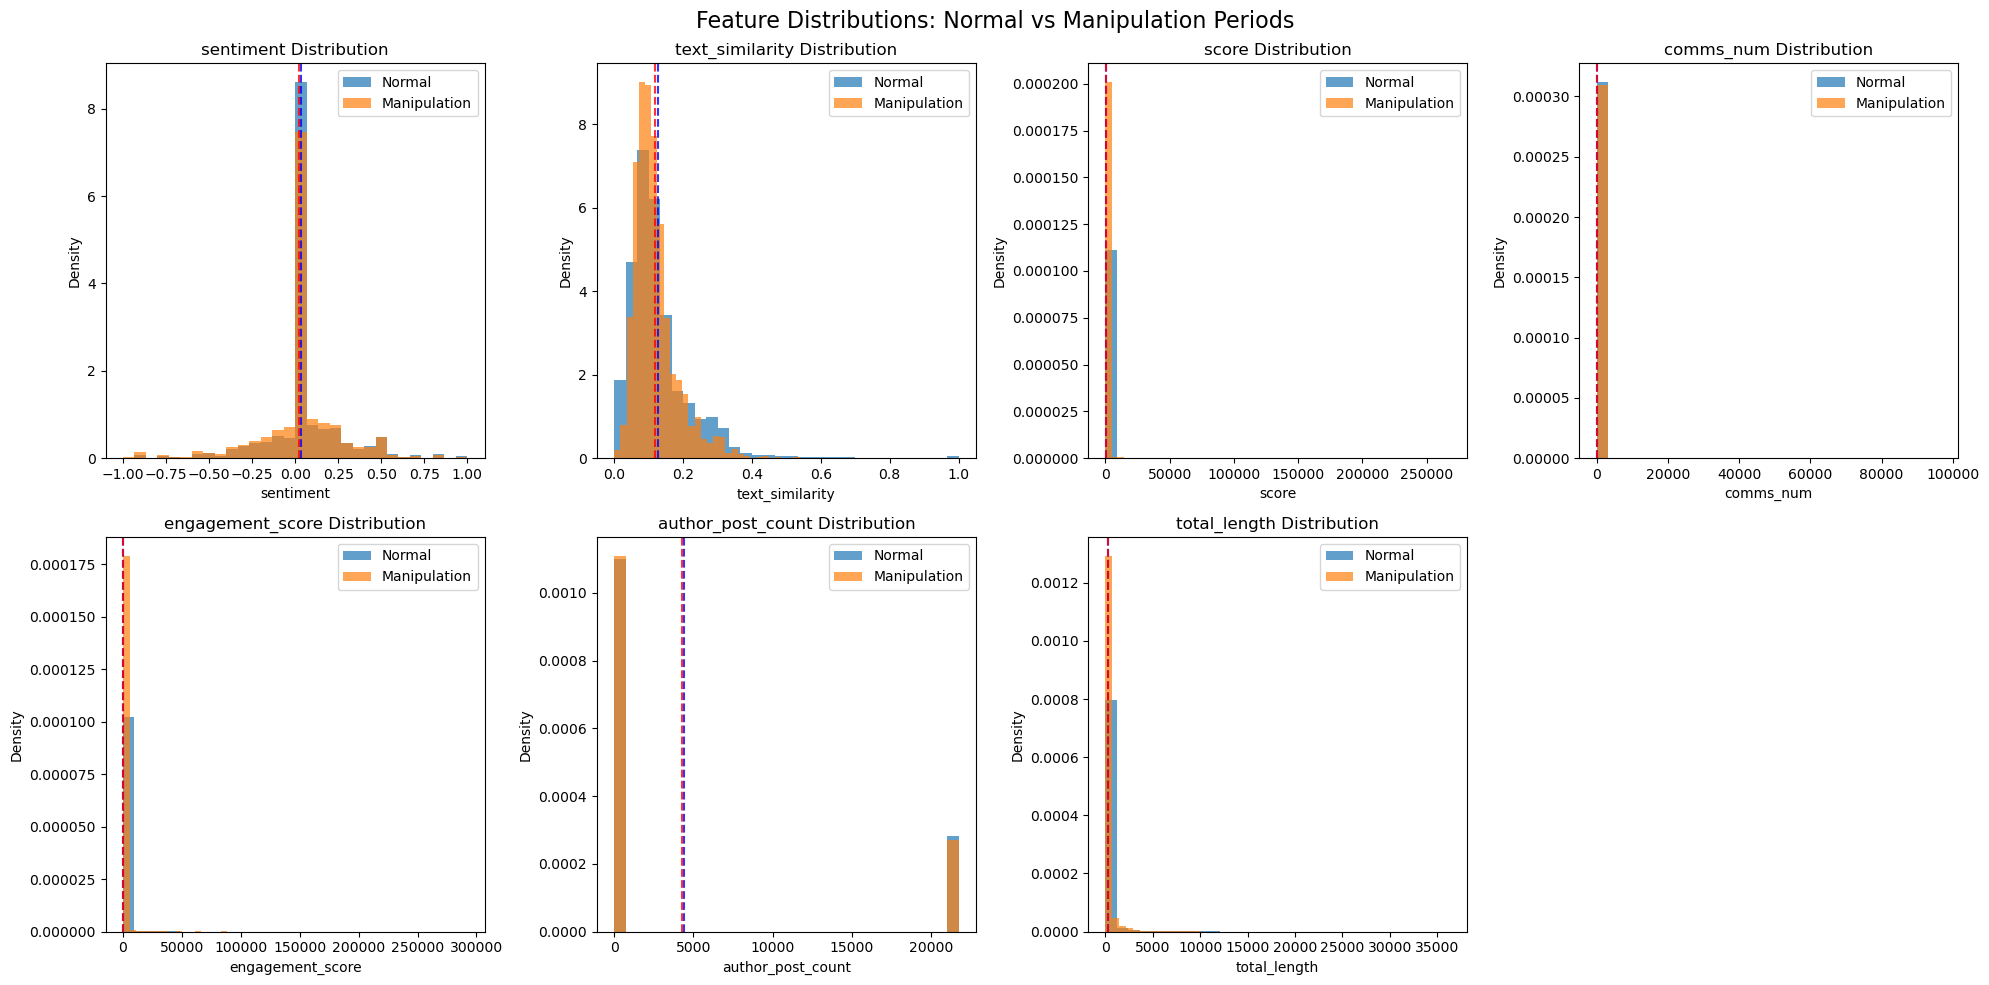

In [221]:
feature_columns = [
    'sentiment', 'text_similarity', 'score', 'comms_num', 
    'engagement_score', 'author_post_count', 'total_length'
]

# Filter to available columns
available_features = [col for col in feature_columns if col in df_wsb_labeled.columns]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(available_features):
    if i >= len(axes):
        break
        
    # Distribution comparison
    normal_data = df_wsb_labeled[df_wsb_labeled['is_manipulation'] == 0][feature]
    manip_data = df_wsb_labeled[df_wsb_labeled['is_manipulation'] == 1][feature]
    
    axes[i].hist(normal_data, bins=30, alpha=0.7, label='Normal', density=True)
    axes[i].hist(manip_data, bins=30, alpha=0.7, label='Manipulation', density=True)
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    
    # Add statistics
    normal_mean = normal_data.mean()
    manip_mean = manip_data.mean()
    axes[i].axvline(normal_mean, color='blue', linestyle='--', alpha=0.8)
    axes[i].axvline(manip_mean, color='red', linestyle='--', alpha=0.8)

# Hide unused subplots
for i in range(len(available_features), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Feature Distributions: Normal vs Manipulation Periods', fontsize=16)
plt.tight_layout()
plt.show()

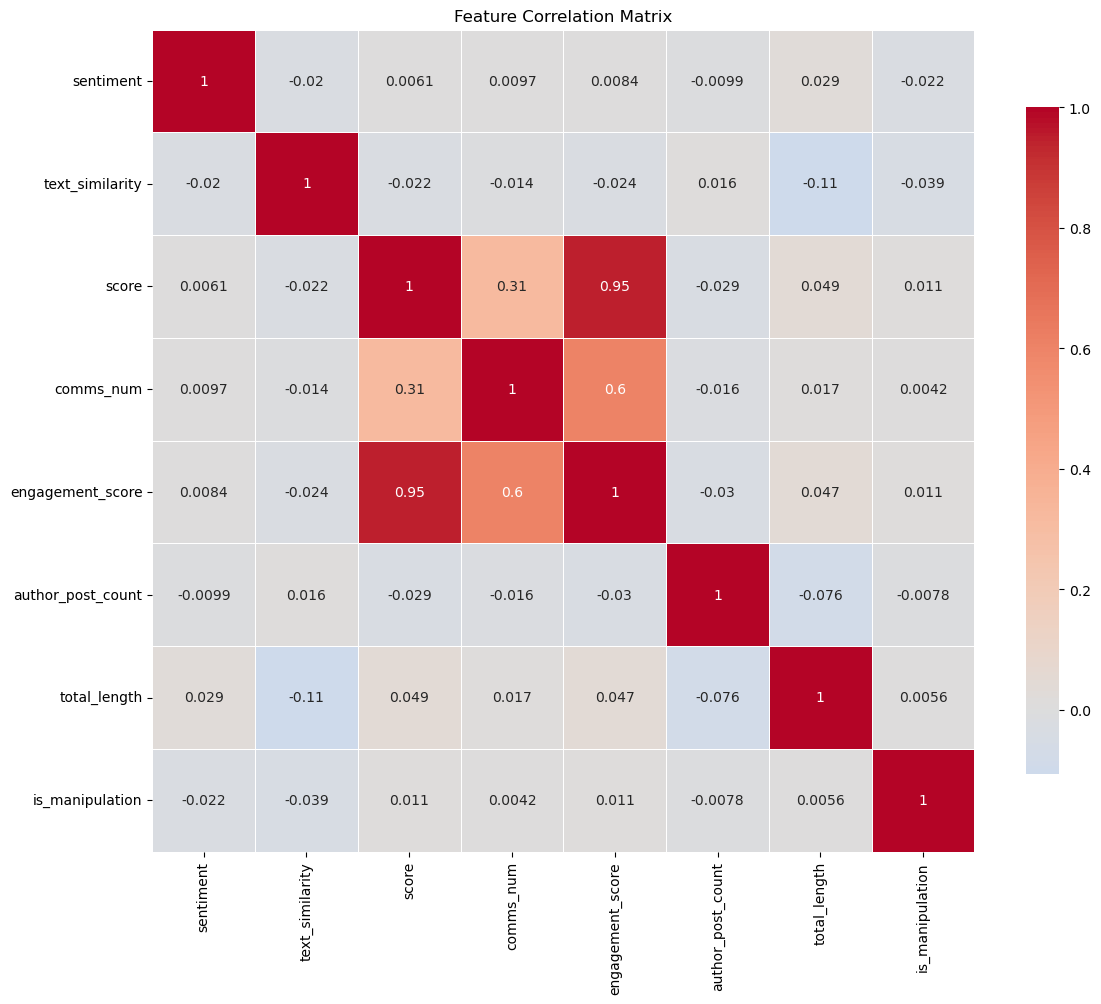


Features most correlated with manipulation:
  text_similarity: 0.039
  sentiment: 0.022
  score: 0.011
  engagement_score: 0.011
  author_post_count: 0.008
  total_length: 0.006
  comms_num: 0.004


In [223]:
feature_columns = [
    'sentiment', 'text_similarity', 'score', 'comms_num', 
    'engagement_score', 'author_post_count', 'total_length', 'is_manipulation'
]

available_features = [col for col in feature_columns if col in df_wsb_labeled.columns]

# Calculate correlation matrix
corr_matrix = df_wsb_labeled[available_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Print highest correlations with manipulation
if 'is_manipulation' in corr_matrix.columns:
    manip_corr = corr_matrix['is_manipulation'].abs().sort_values(ascending=False)
    print("\nFeatures most correlated with manipulation:")
    for feature, corr in manip_corr.items():
        if feature != 'is_manipulation':
            print(f"  {feature}: {corr:.3f}")

AUTHOR BEHAVIOR ANALYSIS
Top 10 most active authors:
  1. [deleted]: 21745 posts
  2. Onboarding92: 179 posts
  3. OPINION_IS_UNPOPULAR: 61 posts
  4. VisualMod: 48 posts
  5. Bscrob: 34 posts
  6. WorldlyAstronaut1065: 30 posts
  7. dhiral1994: 29 posts
  8. Craneteam: 29 posts
  9. Chillznday: 28 posts
  10. sportifynews: 27 posts

Authors with high manipulation period activity (>50% of posts):
Total authors: 108
Most suspicious authors:
  1gvan: 0.80 (4.0/5.0)
  2old-you: 1.00 (6.0/6.0)
  AcanthisittaNorth698: 0.60 (3.0/5.0)
  AdMoist2380: 1.00 (14.0/14.0)
  Adeptness_Potential: 0.60 (3.0/5.0)


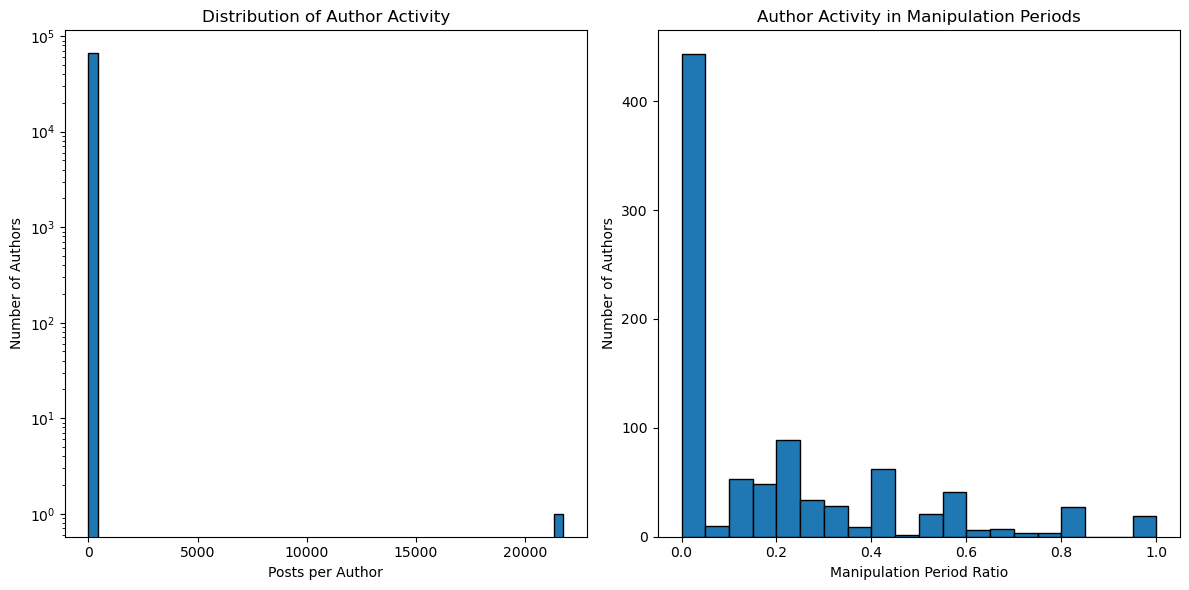

In [224]:
print("=" * 50)
print("AUTHOR BEHAVIOR ANALYSIS")
print("=" * 50)

# Top authors by post count
author_counts = df_wsb_labeled['author'].value_counts()
print(f"Top 10 most active authors:")
for i, (author, count) in enumerate(author_counts.head(10).items()):
    print(f"  {i+1}. {author}: {count} posts")

# Author activity in manipulation vs normal periods
author_manip_ratio = df_wsb_labeled.groupby('author')['is_manipulation'].agg(['count', 'sum'])
author_manip_ratio['manipulation_ratio'] = author_manip_ratio['sum'] / author_manip_ratio['count']

# Filter authors with at least 5 posts
active_authors = author_manip_ratio[author_manip_ratio['count'] >= 5]
suspicious_authors = active_authors[active_authors['manipulation_ratio'] > 0.5]

print(f"\nAuthors with high manipulation period activity (>50% of posts):")
print(f"Total authors: {len(suspicious_authors)}")

if len(suspicious_authors) > 0:
    print("Most suspicious authors:")
    for author, row in suspicious_authors.head(5).iterrows():
        print(f"  {author}: {row['manipulation_ratio']:.2f} ({row['sum']}/{row['count']})")

# Plot author activity distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(author_counts.values, bins=50, edgecolor='black')
plt.xlabel('Posts per Author')
plt.ylabel('Number of Authors')
plt.title('Distribution of Author Activity')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(active_authors['manipulation_ratio'], bins=20, edgecolor='black')
plt.xlabel('Manipulation Period Ratio')
plt.ylabel('Number of Authors')
plt.title('Author Activity in Manipulation Periods')

plt.tight_layout()
plt.show()

Most of them were deleted or removed

Suggested sequence length: 8 days
Significant autocorrelations found at lags: [1, 2, 3, 4, 5, 6, 7, 8]


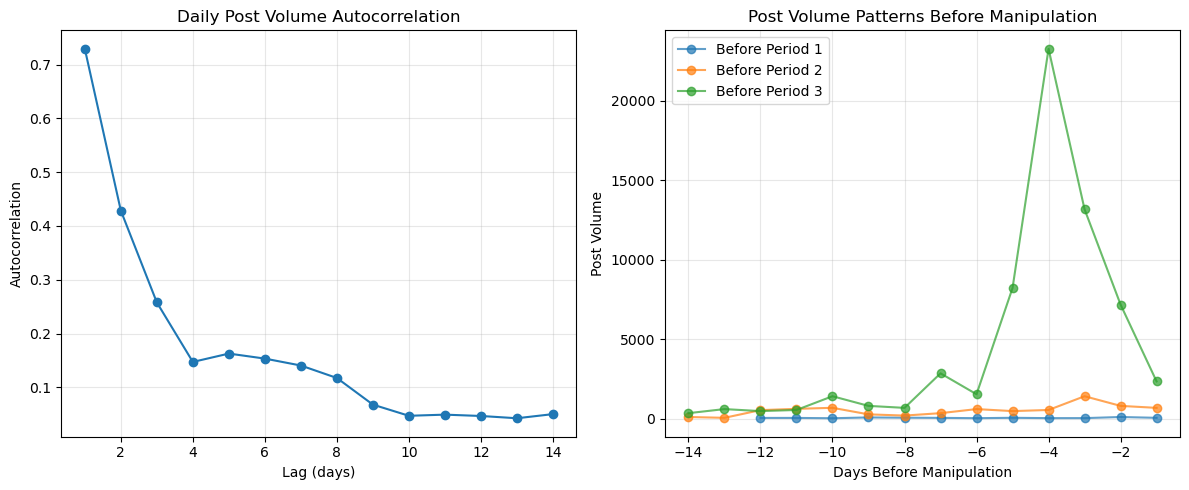

In [225]:
# Analyze appropriate sequence lengths
daily_posts = df_wsb_labeled.groupby(df_wsb_labeled['timestamp'].dt.date).size()

# Calculate autocorrelation for different lags
lags = range(1, 15)
autocorrelations = []

for lag in lags:
    corr = daily_posts.autocorr(lag=lag)
    autocorrelations.append(corr)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lags, autocorrelations, 'o-')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Daily Post Volume Autocorrelation')
plt.grid(True, alpha=0.3)

# Find optimal sequence length
significant_lags = [lag for lag, corr in zip(lags, autocorrelations) if abs(corr) > 0.1]
optimal_sequence_length = max(significant_lags) if significant_lags else 7

print(f"Suggested sequence length: {optimal_sequence_length} days")
print(f"Significant autocorrelations found at lags: {significant_lags}")

# Analyze patterns before manipulation events
plt.subplot(1, 2, 2)

for i, (start, end) in enumerate(manipulation_periods):
    # Get 14 days before manipulation period
    lookback_start = start - timedelta(days=14)
    lookback_data = daily_posts[
        (daily_posts.index >= lookback_start.date()) & 
        (daily_posts.index < start.date())
    ]
    
    if len(lookback_data) > 0:
        days_before = range(-len(lookback_data), 0)
        plt.plot(days_before, lookback_data.values, 'o-', 
                label=f'Before Period {i+1}', alpha=0.7)

plt.xlabel('Days Before Manipulation')
plt.ylabel('Post Volume')
plt.title('Post Volume Patterns Before Manipulation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [226]:
print("=" * 50)
print("MODEL DESIGN RECOMMENDATIONS")
print("=" * 50)

# Class imbalance
normal_posts = (df_wsb_labeled['is_manipulation'] == 0).sum()
manip_posts = (df_wsb_labeled['is_manipulation'] == 1).sum()
imbalance_ratio = normal_posts / manip_posts

print(f"1. CLASS IMBALANCE:")
print(f"   Ratio: {imbalance_ratio:.1f}:1")
if imbalance_ratio > 10:
    print("   Recommendation: Use class weighting or SMOTE")

# Sequence length
daily_posts = df_wsb_labeled.groupby(df_wsb_labeled['timestamp'].dt.date).size()
autocorr_7 = daily_posts.autocorr(lag=7)
autocorr_14 = daily_posts.autocorr(lag=14)

print(f"\n2. SEQUENCE LENGTH:")
print(f"   7-day autocorrelation: {autocorr_7:.3f}")
print(f"   14-day autocorrelation: {autocorr_14:.3f}")

if abs(autocorr_14) > abs(autocorr_7):
    print("   Recommendation: Use 14-day sequences")
else:
    print("   Recommendation: Use 7-day sequences")

# Feature importance
if 'text_similarity' in df_wsb_labeled.columns:
    text_sim_corr = df_wsb_labeled['text_similarity'].corr(df_wsb_labeled['is_manipulation'])
    print(f"\n3. KEY FEATURES:")
    print(f"   Text similarity correlation: {text_sim_corr:.3f}")
    
    if abs(text_sim_corr) > 0.1:
        print("   Recommendation: Text similarity is a strong signal")

# Data quality
missing_pct = df_wsb_labeled.isnull().sum().sum() / (len(df_wsb_labeled) * len(df_wsb_labeled.columns))
print(f"\n4. DATA QUALITY:")
print(f"   Missing data: {missing_pct:.1%}")

if missing_pct > 0.05:
    print("   Recommendation: Implement robust missing data handling")

print(f"\n5. TRAINING STRATEGY:")
print(f"   Recommendation: Use stratified train/test split")
print(f"   Recommendation: Implement early stopping with validation")
print(f"   Recommendation: Use focal loss for class imbalance")

MODEL DESIGN RECOMMENDATIONS
1. CLASS IMBALANCE:
   Ratio: 4.5:1

2. SEQUENCE LENGTH:
   7-day autocorrelation: 0.141
   14-day autocorrelation: 0.050
   Recommendation: Use 7-day sequences

3. KEY FEATURES:
   Text similarity correlation: -0.039

4. DATA QUALITY:
   Missing data: 0.9%

5. TRAINING STRATEGY:
   Recommendation: Use stratified train/test split
   Recommendation: Implement early stopping with validation
   Recommendation: Use focal loss for class imbalance
